<a href="https://colab.research.google.com/github/DinhLongHuynh/Ames_prediction/blob/main/Ames_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

# **1. LOADING AND HANDLING DATASET**

In [4]:
# Load data
df_descriptor_raw = pd.read_csv('ames.AZ_descriptors_tr.csv', sep = ";", low_memory = False, na_values = '?')
df_ecfi_raw = pd.read_csv('ames.ecfi1024_tr.csv', sep = ";", na_values = '?')
df_oeaselma_raw = pd.read_csv('ames.oeselma_tr.csv',sep =";", na_values = '?')
df_wfp_raw = pd.read_csv('ames.wfp_tr.csv', sep = ";", na_values = '?')

# Merge datasets into 1 dataset
combination = [df_descriptor_raw,df_ecfi_raw, df_oeaselma_raw, df_wfp_raw]
merged_df_raw = pd.concat(combination, axis=1)
merged_df_raw = merged_df_raw.loc[:,~merged_df_raw.columns.duplicated()]

# Drop unneccessary columns
merged_df_drop = merged_df_raw.drop(['ID','ames','set'], axis = 1)

In [6]:
# Standardized data
merged_df_standard = StandardScaler().fit_transform(merged_df_drop)
merged_df_standard = pd.DataFrame(merged_df_standard, columns = merged_df_drop.columns)
merged_df_standard.head()


,ACDlogD65,ACDlogD74,ACDlogP,GClogP,NNlogP,ClogP,HBA_nonLipinski,HBD_nonLipinski,HBA,HBD,...,wfp115,wfp116,wfp117,wfp118,wfp119,wfp120,wfp121,wfp122,wfp123,wfp124
0,-0.647313,-0.611775,-1.188632,-1.233167,-1.285814,-1.097869,-0.449913,-0.136022,-0.503985,-0.132488,...,-0.138893,-0.919187,-0.887847,-1.091300,4.498182,1.041347,-1.030845,0.689438,-0.129546,0.277547
1,NaN,NaN,NaN,-2.084871,-2.205538,-1.223187,0.177205,1.371501,0.106141,1.376350,...,-0.138893,-0.919187,-0.887847,-1.091300,-0.222312,-0.960295,-1.030845,0.689438,-0.129546,0.277547
2,-0.659611,-0.623658,-1.207548,-1.734254,-1.446198,-1.149880,-0.136354,0.366485,0.411204,0.370458,...,-0.138893,1.087918,1.126320,0.916338,-0.222312,-0.960295,0.970078,0.689438,-0.129546,0.277547
3,-0.207629,-0.186966,-0.589599,-0.557727,-0.526001,-0.522468,-0.449913,-0.136022,-0.503985,-0.132488,...,-0.138893,-0.919187,1.126320,-1.091300,-0.222312,1.041347,0.970078,0.689438,-0.129546,0.277547
4,-0.216853,-0.189936,-0.594223,-0.828094,-1.306631,-0.589633,-0.763473,0.868993,-0.198922,0.873404,...,-0.138893,-0.919187,-0.887847,0.916338,-0.222312,1.041347,-1.030845,0.689438,-0.129546,0.277547


In [7]:
# Handle missing value
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
data = imp.fit_transform(merged_df_standard)
merged_df_standard = pd.DataFrame(data,columns=merged_df_standard.columns)

merged_df_standard.head()

,ACDlogD65,ACDlogD74,ACDlogP,GClogP,NNlogP,ClogP,HBA_nonLipinski,HBD_nonLipinski,HBA,HBD,...,wfp115,wfp116,wfp117,wfp118,wfp119,wfp120,wfp121,wfp122,wfp123,wfp124
0,-6.473125e-01,-6.117755e-01,-1.188632e+00,-1.233167,-1.285814,-1.097869,-0.449913,-0.136022,-0.503985,-0.132488,...,-0.138893,-0.919187,-0.887847,-1.091300,4.498182,1.041347,-1.030845,0.689438,-0.129546,0.277547
1,1.556807e-17,7.185264e-17,4.973799e-17,-2.084871,-2.205538,-1.223187,0.177205,1.371501,0.106141,1.376350,...,-0.138893,-0.919187,-0.887847,-1.091300,-0.222312,-0.960295,-1.030845,0.689438,-0.129546,0.277547
2,-6.596114e-01,-6.236583e-01,-1.207548e+00,-1.734254,-1.446198,-1.149880,-0.136354,0.366485,0.411204,0.370458,...,-0.138893,1.087918,1.126320,0.916338,-0.222312,-0.960295,0.970078,0.689438,-0.129546,0.277547
3,-2.076292e-01,-1.869657e-01,-5.895986e-01,-0.557727,-0.526001,-0.522468,-0.449913,-0.136022,-0.503985,-0.132488,...,-0.138893,-0.919187,1.126320,-1.091300,-0.222312,1.041347,0.970078,0.689438,-0.129546,0.277547
4,-2.168533e-01,-1.899364e-01,-5.942228e-01,-0.828094,-1.306631,-0.589633,-0.763473,0.868993,-0.198922,0.873404,...,-0.138893,-0.919187,-0.887847,0.916338,-0.222312,1.041347,-1.030845,0.689438,-0.129546,0.277547


In [8]:
corre_matrix = merged_df_standard.corr()

In [9]:
# Cut off high correlated features
threshold = 0.9
corre_features = []
for i in range(len(corre_matrix.columns)):
    for j in range(i):
        if abs(corre_matrix.iloc[i, j]) > threshold:
            colname = corre_matrix.columns[i]
            corre_features.append(colname)

df_filtered = merged_df_standard.drop(columns=corre_features, axis=1)

In [10]:
df_filtered
# 188 highly correlated was filtered out

,ACDlogD65,ACDlogP,GClogP,HBA_nonLipinski,HBD_nonLipinski,HBAmax,HBDmax,SAS_HB_A_AREA,SPEC_HB_TOT,SPEC_SAS_HB_A_AREA,...,wfp115,wfp116,wfp117,wfp118,wfp119,wfp120,wfp121,wfp122,wfp123,wfp124
0,-6.473125e-01,-1.188632e+00,-1.233167,-0.449913,-0.136022,0.273912,-0.436597,-0.467027,0.955910,-0.048303,...,-0.138893,-0.919187,-0.887847,-1.091300,4.498182,1.041347,-1.030845,0.689438,-0.129546,0.277547
1,1.556807e-17,4.973799e-17,-2.084871,0.177205,1.371501,-0.522802,-0.493078,0.475114,2.782500,1.163035,...,-0.138893,-0.919187,-0.887847,-1.091300,-0.222312,-0.960295,-1.030845,0.689438,-0.129546,0.277547
2,-6.596114e-01,-1.207548e+00,-1.734254,-0.136354,0.366485,0.963653,-0.535214,0.672950,1.217053,1.900402,...,-0.138893,1.087918,1.126320,0.916338,-0.222312,-0.960295,0.970078,0.689438,-0.129546,0.277547
3,-2.076292e-01,-5.895986e-01,-0.557727,-0.449913,-0.136022,0.273912,-0.499353,-0.433908,0.016548,-0.197490,...,-0.138893,-0.919187,1.126320,-1.091300,-0.222312,1.041347,0.970078,0.689438,-0.129546,0.277547
4,-2.168533e-01,-5.942228e-01,-0.828094,-0.763473,0.868993,-0.843723,-0.544179,-0.418667,0.486229,-0.104694,...,-0.138893,-0.919187,-0.887847,0.916338,-0.222312,1.041347,-1.030845,0.689438,-0.129546,0.277547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4539,6.194674e-01,5.412073e-01,1.008108,0.177205,-0.136022,0.912561,-0.185570,0.142162,-0.218292,-0.281006,...,-0.138893,1.087918,1.126320,-1.091300,-0.222312,1.041347,-1.030845,-1.450457,-0.129546,0.277547
4540,-1.676580e-01,-5.336889e-01,-0.823795,0.177205,1.371501,-0.385493,0.531649,1.269390,1.738868,2.103838,...,-0.138893,1.087918,1.126320,-1.091300,-0.222312,1.041347,-1.030845,0.689438,-0.129546,-3.602990
4541,-7.518526e-01,-1.334081e+00,-0.961845,0.490764,-0.638530,1.137684,0.979911,1.144827,0.284736,1.593463,...,-0.138893,1.087918,-0.887847,0.916338,-0.222312,1.041347,0.970078,0.689438,-0.129546,-3.602990
4542,-1.215374e-01,-4.718939e-01,0.079020,0.490764,-0.638530,1.854568,0.979911,1.159481,-0.371408,0.879652,...,-0.138893,1.087918,1.126320,0.916338,-0.222312,-0.960295,0.970078,-1.450457,-0.129546,0.277547


In [11]:
# Split data into training and testing set
X = df_filtered
Y = merged_df_raw['ames']
X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 246)

# **2. APPLY KNN CLASSIFICATION**

In [31]:
# Using GridSearchCV to find optimal model
n_neighbors = range(1,20)
parameter = {'n_neighbors': n_neighbors}
knn_model = KNeighborsClassifier()
knn_grid_model = GridSearchCV(knn_model, parameter, scoring = 'accuracy', cv = 10)
knn_grid_model.fit(X_train,Y_train)


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 20)}, scoring='accuracy')

In [32]:
# Extract accuracy values from CV
mean_accuracy = knn_grid_model.cv_results_['mean_test_score']
std_accuracy = knn_grid_model.cv_results_['std_test_score']
CI_accuracy = 1.96*std_accuracy/np.sqrt(10)

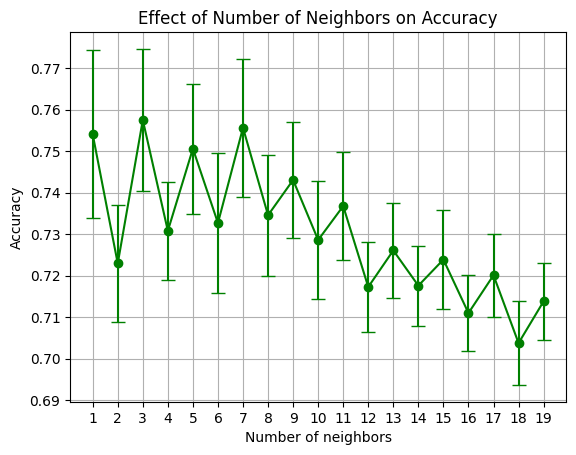

In [33]:
# Plot the results
fig, ax = plt.subplots()
ax.errorbar(n_neighbors, mean_accuracy, yerr= CI_accuracy,
             fmt='o-', label='RMSE', color = 'green', capsize = 5)
ax.set_xlabel('Number of neighbors')
ax.set_xticks(n_neighbors)
ax.grid(True)
ax.set_ylabel('Accuracy')
ax.set_title('Effect of Number of Neighbors on Accuracy')
plt.show()


With the 95%CI, the optimal number of neighbors was determine as 3.

In [34]:
# APPLY PCA INTO KNN CLASSIFICATION
# Find optimal n_neighbors and pca components
pipeline = Pipeline([
    ('pca', PCA()),
    ('classifier', KNeighborsClassifier(n_neighbors = 3))
])

parameter = {'pca__n_components': [20,50,100,200,500]}

knn_pca_grid_model = GridSearchCV(pipeline, parameter, scoring = 'accuracy', cv = 10)
knn_pca_grid_model.fit(X_train,Y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('classifier',
                                        KNeighborsClassifier(n_neighbors=3))]),
             param_grid={'pca__n_components': [20, 50, 100, 200, 500]},
             scoring='accuracy')

In [35]:
# Extract accuracy values from CV
mean_accuracy = knn_pca_grid_model.cv_results_['mean_test_score']
std_accuracy = knn_pca_grid_model.cv_results_['std_test_score']
CI_accuracy = 1.96*std_accuracy/np.sqrt(10)

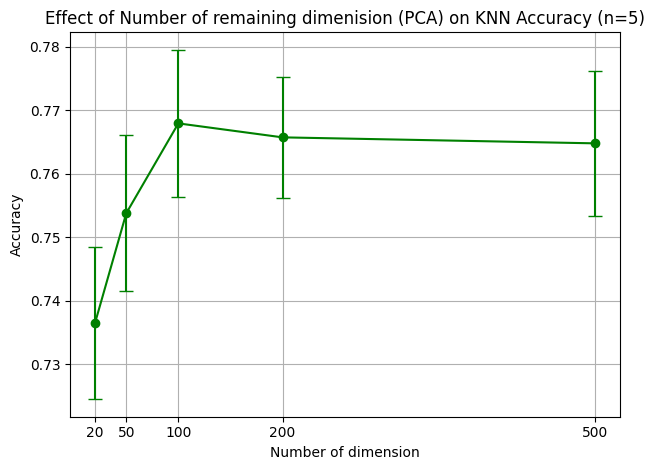

In [36]:
# Plot the results
fig, ax = plt.subplots()
ax.errorbar([20,50,100,200,500], mean_accuracy, yerr= CI_accuracy,
             fmt='o-', label='RMSE', color = 'green', capsize = 5)
ax.set_xlabel('Number of dimension')
ax.set_xticks([20,50,100,200,500])
ax.grid(True)
ax.set_ylabel('Accuracy')
ax.set_title('Effect of Number of remaining dimenision (PCA) on KNN Accuracy (n=5)')
plt.tight_layout()
plt.show()

**PCA has the highest accuracy with small number of dimension (100), imporve a bit than initial data **

# **3. APPLY SVM CLASSIFICATION**

In [18]:
# Find the optimal parameters for SVC
param_options = {'C': [100, 1000],
              'gamma':[ 0.01, 0.001],
             'kernel' :['rbf']}
svm_grid_model = GridSearchCV(SVC(), param_options, cv = 10, scoring = 'accuracy')
svm_grid_model.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [100, 1000], 'gamma': [0.01, 0.001],
                         'kernel': ['rbf']},
             scoring='accuracy')

In [26]:
print(f'Best parameters: {svm_grid_model.best_params_}')

Best parameters: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


In [25]:
best_estimated_position = svm_grid_model.cv_results_['params'].index({'C': 100, 'gamma': 0.001, 'kernel': 'rbf'})
mean_accuracy = svm_grid_model.cv_results_['mean_test_score'][best_estimated_position]
std_accuracy = svm_grid_model.cv_results_['std_test_score'][best_estimated_position]
CI_range = 1.96*std_accuracy/np.sqrt(10)

In [27]:
print(f'Mean Accuracy: {mean_accuracy}')
print(f'95% range: {CI_range}')

Mean Accuracy: 0.7977987421383649
95% range: 0.010204305898312843


In [28]:
# APPLY PCA INTO SVM CLASSIFICATION
# Find optimal n_neighbors and pca components
pipeline = Pipeline([
    ('pca', PCA()),
    ('classifier', SVC(kernel = 'rbf', C = 100, gamma=0.001))
])

PCA_trial = [20,50,100,200,500]
parameter = {'pca__n_components': PCA_trial}

svm_pca_grid_model = GridSearchCV(pipeline, parameter, scoring = 'accuracy', cv = 10)
svm_pca_grid_model.fit(X_train,Y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('classifier',
                                        SVC(C=100, gamma=0.001))]),
             param_grid={'pca__n_components': [20, 50, 100, 200, 500]},
             scoring='accuracy')

In [29]:
# Extract accuracy values from CV
mean_accuracy = svm_pca_grid_model.cv_results_['mean_test_score']
std_accuracy = svm_pca_grid_model.cv_results_['std_test_score']
CI_accuracy = 1.96*std_accuracy/np.sqrt(10)

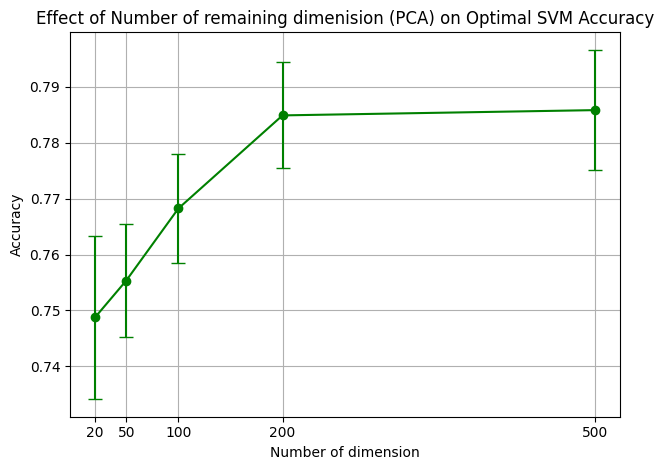

In [30]:
# Plot the results
fig, ax = plt.subplots()
ax.errorbar([20,50,100,200,500], mean_accuracy, yerr= CI_accuracy,
             fmt='o-', label='RMSE', color = 'green', capsize = 5)
ax.set_xlabel('Number of dimension')
ax.set_xticks([20,50,100,200,500])
ax.grid(True)
ax.set_ylabel('Accuracy')
ax.set_title('Effect of Number of remaining dimenision (PCA) on Optimal SVM Accuracy')
plt.tight_layout()
plt.show()

with PCA, the highest accuracy was achieved when 500 dimensions was made. It has higher bias but lower variance than the initial model using all features.

# **4. APPLY RANDOM FOREST CLASSIFICATION**

In [39]:
# Optimize parameter
param_grid = {'n_estimators': [100, 200, 300, 400, 500]}
forest_grid = GridSearchCV(RandomForestClassifier(), param_grid, scoring = 'accuracy', cv = 10)
forest_grid.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [100, 200, 300, 400, 500]},
             scoring='accuracy')

In [40]:
# Extract accuracy values from CV
mean_accuracy = svm_pca_grid_model.cv_results_['mean_test_score']
std_accuracy = svm_pca_grid_model.cv_results_['std_test_score']
CI_accuracy = 1.96*std_accuracy/np.sqrt(10)

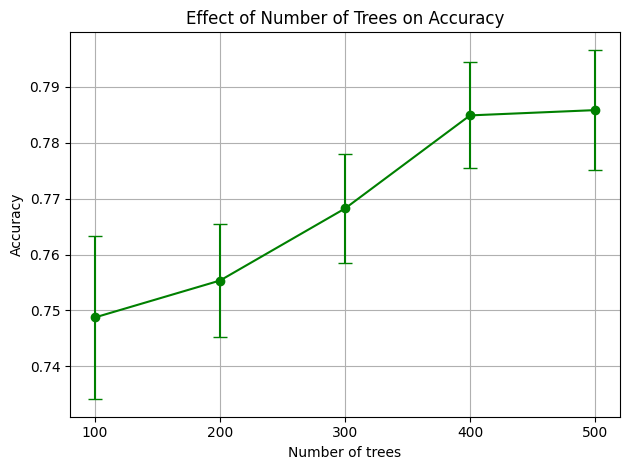

In [41]:
# Plot the results
fig, ax = plt.subplots()
ax.errorbar([100, 200, 300, 400, 500], mean_accuracy, yerr= CI_accuracy,
             fmt='o-', label='RMSE', color = 'green', capsize = 5)
ax.set_xlabel('Number of trees')
ax.set_xticks([100, 200, 300, 400, 500])
ax.grid(True)
ax.set_ylabel('Accuracy')
ax.set_title('Effect of Number of Trees on Accuracy')
plt.tight_layout()
plt.show()

500 trees give the highest accuracy models

# **5. COMPARISION OF MODEL**

In [77]:
# Apply PCA (100) and KNN (k=3)
knn_prediction = knn_pca_grid_model.predict(x_test)
knn_accuracy = accuracy_score(y_test, knn_prediction)
knn_conf_matrix = confusion_matrix(y_test, knn_prediction)
knn_results = pd.DataFrame(knn_conf_matrix, columns = ['Actual Negative', 'Actual Positive'],index=['Predicted Negative','Predicted Positive'])

In [78]:
# Apply PCA (500) and SVM ({'C': 100, 'gamma': 0.001, 'kernel': 'rbf'})
svm_prediction = svm_pca_grid_model.predict(x_test)
svm_accuracy = accuracy_score(y_test, svm_prediction)
svm_conf_matrix = confusion_matrix(y_test, svm_prediction)
svm_results = pd.DataFrame(svm_conf_matrix, columns = ['Actual Negative', 'Actual Positive'],index=['Predicted Negative','Predicted Positive'])

In [79]:
# Apply optimal random forest models
rf_prediction = forest_grid.predict(x_test)
rf_accuracy = accuracy_score(y_test, rf_prediction)
rf_conf_matrix = confusion_matrix(y_test, rf_prediction)
rf_results = pd.DataFrame(rf_conf_matrix, columns = ['Actual Negative', 'Actual Positive'],index=['Predicted Negative','Predicted Positive'])

In [80]:
print('Optiaml KNN model with PCA')
print(f'Accuracy: {knn_accuracy}')
print(knn_results)
print('\n\n')
print('Optiaml SVM model with PCA')
print(f'Accuracy: {svm_accuracy}')
print(svm_results)
print('\n\n')
print('Optiaml RF model')
print(f'Accuracy: {rf_accuracy}')
print(rf_results)

Optiaml KNN model with PCA
Accuracy: 0.7866568914956011
                    Actual Negative  Actual Positive
Predicted Negative              523              121
Predicted Positive              170              550



Optiaml SVM model with PCA
Accuracy: 0.8013196480938416
                    Actual Negative  Actual Positive
Predicted Negative              512              132
Predicted Positive              139              581



Optiaml RF model
Accuracy: 0.8233137829912024
                    Actual Negative  Actual Positive
Predicted Negative              539              105
Predicted Positive              136              584


**Conclusion**
The highest accuracy model was RF with 500 trees. The accuracy on test set was 82.3%.

# **6. APPLY FINAL MODEL FOR FUTURE PREDICTION**

In [81]:
# Load the predict_required set
# Load data
predict_descriptor_raw = pd.read_csv('ames.AZ_descriptors_ts.csv', sep = ";", low_memory = False, na_values = '?')
predict_ecfi_raw = pd.read_csv('ames.ecfi1024_ts.csv', sep = ";", na_values = '?')
predict_oeaselma_raw = pd.read_csv('ames.oeselma_ts.csv',sep =";", na_values = '?')
predict_wfp_raw = pd.read_csv('ames.wfp_ts.csv', sep = ";", na_values = '?')

# Merge datasets into 1 dataset
combination = [predict_descriptor_raw,predict_ecfi_raw, predict_oeaselma_raw, predict_wfp_raw]
merged_predict_raw = pd.concat(combination, axis=1)
merged_predict_raw = merged_predict_raw.loc[:,~merged_predict_raw.columns.duplicated()]
merged_predict_X_space = merged_predict_raw.drop(['ID','ames','set'], axis = 1)
merged_predict_X_space.head()



,ACDlogD65,ACDlogD74,ACDlogP,GClogP,NNlogP,ClogP,HBA_nonLipinski,HBD_nonLipinski,HBA,HBD,...,wfp115,wfp116,wfp117,wfp118,wfp119,wfp120,wfp121,wfp122,wfp123,wfp124
0,8.72,8.72,8.720,7.752,6.173,8.840,6.0,2.0,8.0,2.0,...,0,0,0,0,0,0,1,0,0,1
1,-3.19,-1.44,1.313,1.953,1.636,2.807,5.0,3.0,5.0,3.0,...,0,1,1,0,0,0,0,0,0,1
2,-0.72,-0.72,-0.720,-0.211,-0.116,-0.572,5.0,4.0,4.0,4.0,...,0,0,0,0,0,0,0,1,0,1
3,1.21,1.39,1.665,2.259,2.015,2.276,4.0,2.0,5.0,2.0,...,0,1,1,0,0,1,0,1,0,1
4,3.36,3.36,3.356,2.792,2.839,3.538,5.0,0.0,3.0,0.0,...,0,1,0,1,0,1,1,0,0,1


In [82]:
# Standardize dataset
scaler = StandardScaler()
merged_predict_X_space_standard = scaler.fit_transform(merged_predict_X_space)
merged_predict_X_space_standard = pd.DataFrame(merged_predict_X_space_standard, columns =merged_predict_X_space.columns)
merged_predict_X_space_standard

,ACDlogD65,ACDlogD74,ACDlogP,GClogP,NNlogP,ClogP,HBA_nonLipinski,HBD_nonLipinski,HBA,HBD,...,wfp115,wfp116,wfp117,wfp118,wfp119,wfp120,wfp121,wfp122,wfp123,wfp124
0,1.999943,1.911654,2.587765,2.535616,1.755926,2.580857,0.593438,0.306971,1.055392,0.311859,...,-0.120137,-0.900271,-0.866539,-1.088228,-0.235006,-0.935987,0.965042,-1.409377,-0.13259,0.284121
1,-1.448174,-0.874202,-0.546912,-0.249324,-0.469021,0.123206,0.307967,0.789634,0.207717,0.795634,...,-0.120137,1.110777,1.154016,-1.088228,-0.235006,-0.935987,-1.036225,-1.409377,-0.13259,0.284121
2,-0.733073,-0.676779,-1.407287,-1.288574,-1.328203,-1.253290,0.307967,1.272297,-0.074841,1.279410,...,-0.120137,-0.900271,-0.866539,-1.088228,-0.235006,-0.935987,-1.036225,0.709533,-0.13259,0.284121
3,-0.174310,-0.098220,-0.397944,-0.102369,-0.283160,-0.093106,0.022495,0.306971,0.207717,0.311859,...,-0.120137,1.110777,1.154016,-1.088228,-0.235006,1.068390,-1.036225,0.709533,-0.13259,0.284121
4,0.448146,0.441950,0.317695,0.153601,0.120931,0.420992,0.307967,-0.658356,-0.357400,-0.655691,...,-0.120137,1.110777,-0.866539,0.918925,-0.235006,1.068390,0.965042,-1.409377,-0.13259,0.284121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1963,0.010979,0.027911,-0.321767,-0.520662,-0.464608,-0.357895,-0.833919,-0.658356,-0.922517,-0.655691,...,-0.120137,-0.900271,1.154016,-1.088228,-0.235006,-0.935987,-1.036225,-1.409377,-0.13259,0.284121
1964,0.375767,0.373401,0.212740,0.097893,-0.188512,0.100801,0.022495,0.306971,0.207717,0.311859,...,-0.120137,1.110777,-0.866539,-1.088228,-0.235006,1.068390,0.965042,0.709533,-0.13259,0.284121
1965,1.470131,1.409871,1.814570,1.286979,1.832429,1.661835,-1.119390,-0.658356,-1.205075,-0.655691,...,-0.120137,1.110777,-0.866539,0.918925,4.255208,1.068390,-1.036225,0.709533,-0.13259,0.284121
1966,-0.246689,-0.397097,-0.563417,0.197784,-0.316997,-0.467070,-0.548447,-0.175692,-0.357400,-0.171916,...,-0.120137,-0.900271,-0.866539,0.918925,4.255208,-0.935987,-1.036225,0.709533,-0.13259,0.284121


In [83]:
# Handling missing values
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
data = imp.fit_transform(merged_predict_X_space_standard)
merged_predict_X_space_standard = pd.DataFrame(data,columns=merged_predict_X_space_standard.columns)

merged_predict_X_space_standard.head()

,ACDlogD65,ACDlogD74,ACDlogP,GClogP,NNlogP,ClogP,HBA_nonLipinski,HBD_nonLipinski,HBA,HBD,...,wfp115,wfp116,wfp117,wfp118,wfp119,wfp120,wfp121,wfp122,wfp123,wfp124
0,1.999943,1.911654,2.587765,2.535616,1.755926,2.580857,0.593438,0.306971,1.055392,0.311859,...,-0.120137,-0.900271,-0.866539,-1.088228,-0.235006,-0.935987,0.965042,-1.409377,-0.13259,0.284121
1,-1.448174,-0.874202,-0.546912,-0.249324,-0.469021,0.123206,0.307967,0.789634,0.207717,0.795634,...,-0.120137,1.110777,1.154016,-1.088228,-0.235006,-0.935987,-1.036225,-1.409377,-0.13259,0.284121
2,-0.733073,-0.676779,-1.407287,-1.288574,-1.328203,-1.253290,0.307967,1.272297,-0.074841,1.279410,...,-0.120137,-0.900271,-0.866539,-1.088228,-0.235006,-0.935987,-1.036225,0.709533,-0.13259,0.284121
3,-0.174310,-0.098220,-0.397944,-0.102369,-0.283160,-0.093106,0.022495,0.306971,0.207717,0.311859,...,-0.120137,1.110777,1.154016,-1.088228,-0.235006,1.068390,-1.036225,0.709533,-0.13259,0.284121
4,0.448146,0.441950,0.317695,0.153601,0.120931,0.420992,0.307967,-0.658356,-0.357400,-0.655691,...,-0.120137,1.110777,-0.866539,0.918925,-0.235006,1.068390,0.965042,-1.409377,-0.13259,0.284121


In [84]:
# Filter out high correlated features with same strategy to the building model set.
X_filtered = merged_predict_X_space_standard.drop(columns=corre_features, axis=1)

In [85]:
X_filtered

,ACDlogD65,ACDlogP,GClogP,HBA_nonLipinski,HBD_nonLipinski,HBAmax,HBDmax,SAS_HB_A_AREA,SPEC_HB_TOT,SPEC_SAS_HB_A_AREA,...,wfp115,wfp116,wfp117,wfp118,wfp119,wfp120,wfp121,wfp122,wfp123,wfp124
0,1.999943,2.587765,2.535616,0.593438,0.306971,0.493689,-0.765611,1.261963,-0.693292,0.060637,...,-0.120137,-0.900271,-0.866539,-1.088228,-0.235006,-0.935987,0.965042,-1.409377,-0.13259,0.284121
1,-1.448174,-0.546912,-0.249324,0.307967,0.789634,1.274301,-0.627132,0.038870,0.263494,-0.262508,...,-0.120137,1.110777,1.154016,-1.088228,-0.235006,-0.935987,-1.036225,-1.409377,-0.13259,0.284121
2,-0.733073,-1.407287,-1.288574,0.307967,1.272297,0.137394,-0.536282,0.374300,2.660046,1.088699,...,-0.120137,-0.900271,-0.866539,-1.088228,-0.235006,-0.935987,-1.036225,0.709533,-0.13259,0.284121
3,-0.174310,-0.397944,-0.102369,0.022495,0.306971,0.320400,-0.465719,0.194314,0.189621,0.203802,...,-0.120137,1.110777,1.154016,-1.088228,-0.235006,1.068390,-1.036225,0.709533,-0.13259,0.284121
4,0.448146,0.317695,0.153601,0.307967,-0.658356,0.493689,1.033743,-0.184204,-0.093135,-0.115252,...,-0.120137,1.110777,-0.866539,0.918925,-0.235006,1.068390,0.965042,-1.409377,-0.13259,0.284121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1963,0.010979,-0.321767,-0.520662,-0.833919,-0.658356,0.012690,1.033743,-0.889562,-0.942424,-0.685868,...,-0.120137,-0.900271,1.154016,-1.088228,-0.235006,-0.935987,-1.036225,-1.409377,-0.13259,0.284121
1964,0.375767,0.212740,0.097893,0.022495,0.306971,0.299346,-0.294604,0.936078,-0.179236,0.793506,...,-0.120137,1.110777,-0.866539,-1.088228,-0.235006,1.068390,0.965042,0.709533,-0.13259,0.284121
1965,1.470131,1.814570,1.286979,-1.119390,-0.658356,-2.065161,1.033743,-1.361482,-1.508446,-1.517590,...,-0.120137,1.110777,-0.866539,0.918925,4.255208,1.068390,-1.036225,0.709533,-0.13259,0.284121
1966,-0.246689,-0.563417,0.197784,-0.548447,-0.175692,-0.737150,-2.079846,-0.043078,0.189621,0.826230,...,-0.120137,-0.900271,-0.866539,0.918925,4.255208,-0.935987,-1.036225,0.709533,-0.13259,0.284121


In [86]:
# Apply the model and predict
prediction_forest = forest_grid.predict(X_filtered)

# Add the prediction into initial
summary = pd.DataFrame()
summary['ID'] = merged_predict_raw['ID']
summary['RandomForest_Prediction'] = prediction_forest

In [94]:
summary.to_csv('DinhLongHuynh_Testing_Results.csv', index=False)